In [1]:
import gc

import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

### leggiamo l'intero LARGE dataset, augmented, dal file in formato Feather

In [2]:
cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        }

In [3]:
# adding new features

def add_new_features(df):
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('uint8')
    df['day'] = pd.to_datetime(df.click_time).dt.day.astype('uint8')
    
    print('group by : ip_app_channel_var_day')
    gp = df[['ip','app', 'channel', 'day']].groupby(by=['ip', 'app', 'channel'])[['day']].var().reset_index().rename(index=str, columns={'day': 'ip_app_channel_var_day'})
    df = df.merge(gp, on=['ip','app', 'channel'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_day_hour_count_chl')
    gp = df[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
    df = df.merge(gp, on=['ip','day','hour'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_app_count_chl')
    gp = df[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
    df = df.merge(gp, on=['ip','app'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_app_os_count_chl')
    gp = df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
    df = df.merge(gp, on=['ip','app', 'os'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_day_chl_var_hour')
    gp = df[['ip','day','hour','channel']].groupby(by=['ip','day','channel'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'qty_var'})
    df = df.merge(gp, on=['ip','day','channel'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_app_os_var_hour')
    gp = df[['ip','app', 'os', 'hour']].groupby(by=['ip', 'app', 'os'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_app_os_var'})
    df = df.merge(gp, on=['ip','app', 'os'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_app_chl_mean_hour')
    gp = df[['ip','app', 'channel','hour']].groupby(by=['ip', 'app', 'channel'])[['hour']].mean().reset_index().rename(index=str, columns={'hour': 'ip_app_channel_mean_hour'})
    df = df.merge(gp, on=['ip','app', 'channel'], how='left')
    del gp
    gc.collect()
    
    return df

In [4]:
# RESTART POINT

orig_train = pd.read_feather("train_augmented.fea")

In [5]:
orig_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184903890 entries, 0 to 184903889
Data columns (total 16 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   ip                        uint32        
 1   app                       uint16        
 2   device                    uint16        
 3   os                        uint16        
 4   channel                   uint16        
 5   click_time                datetime64[ns]
 6   is_attributed             uint8         
 7   hour                      uint8         
 8   day                       uint8         
 9   ip_app_channel_var_day    float64       
 10  qty                       uint16        
 11  ip_app_count              uint16        
 12  ip_app_os_count           uint16        
 13  qty_var                   float64       
 14  ip_app_os_var             float64       
 15  ip_app_channel_mean_hour  float64       
dtypes: datetime64[ns](1), float64(4), uint16(7), uint3

* il dataset è estremamente sbilanciato... andrebbe fatto downsampling della classe 0
* il downsampling lo faccio dopo lo split train validation

In [6]:
TARGET = 'is_attributed'

# train, validation split
TRAIN_FRAC = 0.98

N_TRAIN = int(orig_train.shape[0] * TRAIN_FRAC)

# shuffle
orig_train = orig_train.sample(frac=1.)

df_train = orig_train[:N_TRAIN]
df_valid = orig_train[N_TRAIN:]

print('Original training samples:', df_train.shape[0])
print('Num. validation samples:', df_valid.shape[0])

Original training samples: 181205812
Num. validation samples: 3698078


In [7]:
orig_train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed',
       'hour', 'day', 'ip_app_channel_var_day', 'qty', 'ip_app_count',
       'ip_app_os_count', 'qty_var', 'ip_app_os_var',
       'ip_app_channel_mean_hour'],
      dtype='object')

In [8]:
# rebalance

# removed ip because it is high card
feat = ['ip', 'app', 'device', 'os', 'channel',
       'hour', 'day', 'ip_app_channel_var_day', 'qty', 'ip_app_count',
       'qty_var', 'ip_app_os_count', 'ip_app_os_var',
       'ip_app_channel_mean_hour']
cat_feat = ['app', 'device', 'os', 'channel']

x_train = df_train[feat]
y_train = df_train[TARGET]

x_valid = df_valid[feat]
y_valid = df_valid[TARGET]

rus = RandomUnderSampler(random_state=0)

x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

In [9]:
%%time

model = lgb.LGBMClassifier(objective='binary', seed=4321, n_jobs=-1, n_estimators=1000, num_leaves = 30, max_depth=15, early_stopping_rounds=10)

best_model = model.fit(x_train_resampled, y_train_resampled, eval_set=[(x_valid, y_valid)], verbose=1, feature_name=feat, categorical_feature=cat_feat, eval_metric = 'auc')

/home/datascience/conda/mlcpuv1/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/datascience/conda/mlcpuv1/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'device', 'os']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.962694	valid_0's binary_logloss: 0.620388
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.963872	valid_0's binary_logloss: 0.56018
[3]	valid_0's auc: 0.964093	valid_0's binary_logloss: 0.509483
[4]	valid_0's auc: 0.964249	valid_0's binary_logloss: 0.466418
[5]	valid_0's auc: 0.964368	valid_0's binary_logloss: 0.429487
[6]	valid_0's auc: 0.965517	valid_0's binary_logloss: 0.397571
[7]	valid_0's auc: 0.966092	valid_0's binary_logloss: 0.369962
[8]	valid_0's auc: 0.966371	valid_0's binary_logloss: 0.345876
[9]	valid_0's auc: 0.96658	valid_0's binary_logloss: 0.324764
[10]	valid_0's auc: 0.966879	valid_0's binary_logloss: 0.306269
[11]	valid_0's auc: 0.96713	valid_0's binary_logloss: 0.289924
[12]	valid_0's auc: 0.967262	valid_0's binary_logloss: 0.27555
[13]	valid_0's auc: 0.967749	valid_0's binary_logloss: 0.262635
[14]	valid_0's auc: 0.967863	valid_0's binary_logloss: 0.251228
[15]	valid_0's auc: 0.967912	valid_0's binary_logloss: 0

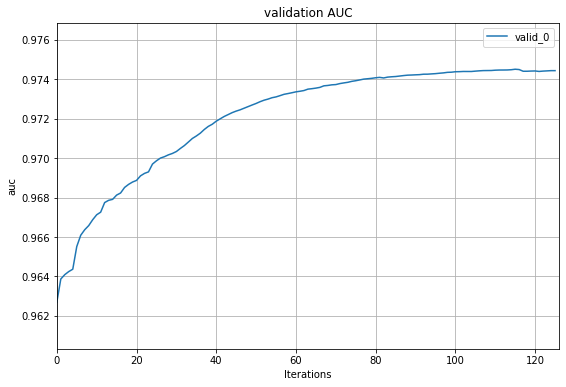

In [10]:
lgb.plot_metric(model, metric='auc', figsize=(9, 6), title='validation AUC');

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

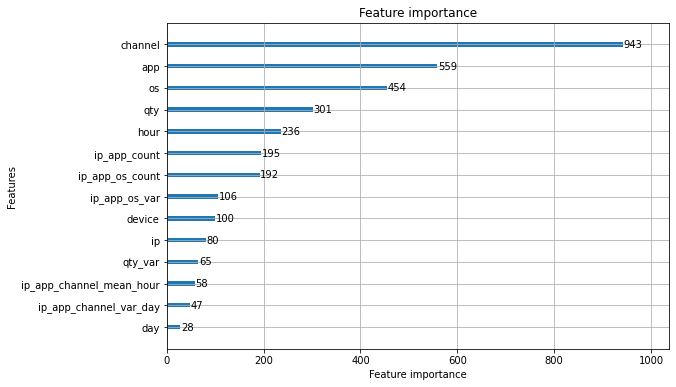

In [11]:
lgb.plot_importance(model, figsize=(9, 6), max_num_features=15)

### Predictions on test set

In [12]:
# make predictions on test set
orig_test = pd.read_csv('test.csv', dtype=dtypes)

# do feature engineering
orig_test = add_new_features(orig_test)

group by : ip_app_channel_var_day
group by : ip_day_hour_count_chl
group by : ip_app_count_chl
group by : ip_app_os_count_chl
group by : ip_day_chl_var_hour
group by : ip_app_os_var_hour
group by : ip_app_chl_mean_hour


In [13]:
orig_test.head()

,click_id,ip,app,device,os,channel,click_time,hour,day,ip_app_channel_var_day,qty,ip_app_count,ip_app_os_count,qty_var,ip_app_os_var,ip_app_channel_mean_hour
0,0,5744,9,1,3,107,2017-11-10 04:00:00,4,10,0.0,34,28,1,0.333333,NaN,4.500000
1,1,119901,9,1,3,466,2017-11-10 04:00:00,4,10,0.0,403,289,5,13.130156,4.700000,8.228571
2,2,72287,21,1,19,128,2017-11-10 04:00:00,4,10,0.0,229,312,24,10.612795,9.027174,7.969697
3,3,78477,15,1,13,111,2017-11-10 04:00:00,4,10,0.0,239,42,23,0.000000,15.873518,4.000000
4,4,123080,12,1,13,328,2017-11-10 04:00:00,4,10,0.0,60,24,7,0.000000,11.904762,4.000000


In [14]:
x_test = orig_test[feat].values

y_probs = best_model.predict_proba(x_test)

y_probs_pos = y_probs[:, 1] 

dict_sub = {}

dict_sub['click_id'] = orig_test['click_id'].values
dict_sub['is_attributed'] = y_probs_pos

df_sub = pd.DataFrame(dict_sub)

SUB_FILE = 'submission5.csv'

df_sub.to_csv(SUB_FILE, index=None)

# !kaggle competitions submit -c talkingdata-adtracking-fraud-detection -f $SUB_FILE -m "third submission"